# Get a custom distribution to work, scale and loc included
Brian Larsen

20180519

Following help from: https://discourse.pymc.io/t/densitydist-from-scipy-stats-distribution/1245/4

In [1]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import theano as tt
import numpy as np
import scipy.stats
import tqdm

sns.set(font_scale=1.5)
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Read in data
Data are the geomagnetic index Dst obtained from George Mason Univ (http://mag.gmu.edu/ftp/OMNI/OMNI2/merged/latest/)

Dst: https://www.ngdc.noaa.gov/stp/geomag/dst.html

I changed the CDF into a pandas dataframe (h5 file) with only the Dst variable

In [2]:
dst = pd.read_hdf('Dst_data.h5')
dst.head()

,Dst
1963-01-01 00:30:00,-6.0
1963-01-01 01:30:00,-5.0
1963-01-01 02:30:00,-5.0
1963-01-01 03:30:00,-3.0
1963-01-01 04:30:00,-3.0


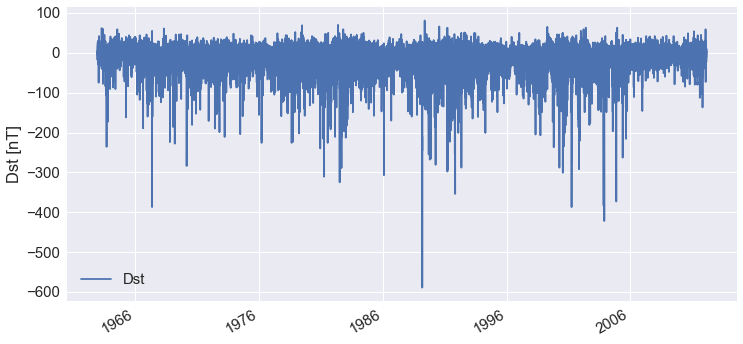

In [3]:
dst = pd.read_hdf('Dst_data.h5')
dst.plot(figsize=(12,6))
plt.ylabel('Dst [nT]');

## Maximum likelihood fit
Use scipy.stats and get a fit to the distribution. At this point no physics in choosing the distribution, it just fit well. 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


scale and loc form scipy: -8.031573809290007 18.887900093929694


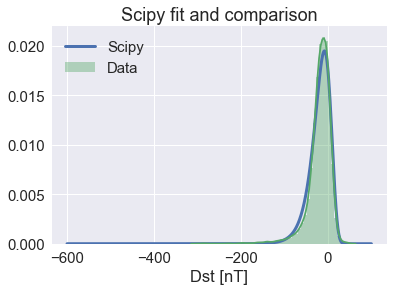

In [4]:

d = scipy.stats.gumbel_l.fit(dst.loc['2000'])
XX = np.linspace(-600, 100, 1000)
plt.plot(XX, scipy.stats.gumbel_l(*d).pdf(XX), label='Scipy', lw=3)

sns.distplot(dst.loc['2000'], label='Data')
plt.xlabel('Dst [nT]')
plt.title('Scipy fit and comparison')
plt.legend();
print('scale and loc form scipy: {} {}'.format(*d))

## Perfrom the fit with pymc3
This will give some more power for the next steps such as fitting an AR model.

In [9]:
# def logp(value):
#      return value - pm.math.exp(value)

# with pm.Model() as model:
#     scale = pm.HalfNormal('scale', sd=10, testval=10)
#     loc = pm.Uniform('loc', -100, 100, testval=0)
#     y = (dst.loc['2000'].values - loc) / scale
#     gumbel_l = pm.DensityDist('gumbel_l', logp, testval=0, observed=y)
#     approx = pm.fit()
    
# trace = approx.sample(10000)


def logp(value, loc, scale):
    value_ = (value - loc)/scale
    logp = value_ - pm.math.exp(value_)
    return logp - pm.math.log(scale)

with pm.Model() as model:
    scale = pm.Uniform('scale', 0, 100, testval=10)
    loc = pm.Uniform('loc', -100, 100, testval=0)
    gumbel_l = pm.DensityDist('gumbel_l', 
                              logp, 
                              observed=dict(value=dst.loc['2000'].values, 
                                            loc=loc, scale=scale))
    trace = pm.sample(5000, n_init=1000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [loc_interval__, scale_interval__]
100%|██████████| 5500/5500 [00:13<00:00, 409.43it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
scale,18.892442,0.154357,0.001664,18.593854,19.197190,8047.744188,1.000415
loc,-8.026749,0.212603,0.002473,-8.441798,-7.612979,8180.569079,1.000011


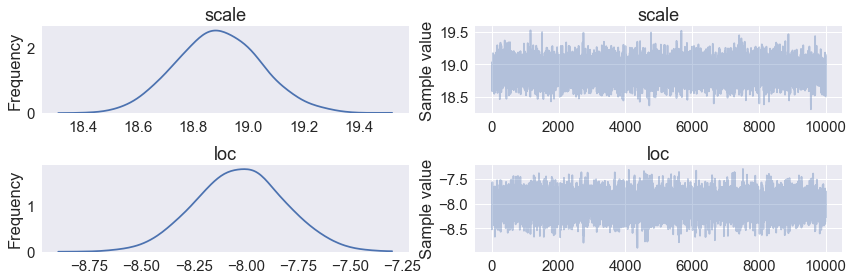

In [10]:
pm.traceplot(trace, combined=True)
pm.summary(trace)

In [11]:
# don't seem to be able to use PPC without defining a random()

#     y = (dst.loc['2000'].values - loc) / scale

ppc = np.asarray([scipy.stats.gumbel_l(scale=trace['scale'][ii], 
                                       loc=trace['loc'][ii]).rvs(size=10)
                  for ii, v in enumerate(np.random.randint(0, len(trace), 1000))])



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(-200, 50)

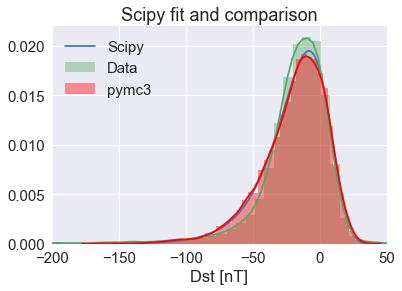

In [15]:
d = scipy.stats.gumbel_l.fit(dst.loc['2000'])
XX = np.linspace(-600, 100, 1000)

plt.plot(XX, scipy.stats.gumbel_l(*d).pdf(XX), label='Scipy')

sns.distplot(dst.loc['2000'], label='Data')

sns.distplot(ppc.flatten(), label='pymc3', color='r',)


plt.xlabel('Dst [nT]')
plt.title('Scipy fit and comparison')
plt.legend();
plt.xlim((-200, 50))

# Do again with a full class


In [ ]:
pm.distributions.generate_samples


In [59]:
from scipy import stats


class Gumbel_l(pm.Continuous):
    def __init__(self, loc, scale, *args, **kwargs):
        super(Gumbel_l, self).__init__(*args, **kwargs)
        self.loc = loc
        self.scale = scale

    def logp(self, value):
        value_ = (value - self.loc)/self.scale
        logp = value_ - pm.math.exp(value_)
        return logp - pm.math.log(self.scale)
    
#     def random(self, point=None, size=None, repeat=None):
#         return scipy.stats.gumbel_l(loc=self.loc, scale=self.scale).rvs(size=size)
    
    
    def random(self, point=None, size=None):
        loc, scale = pm.distributions.draw_values([self.loc, self.scale],
                                 point=point)
        return  pm.distributions.generate_samples(stats.gumbel_l.rvs, loc=loc, scale=scale,
                                size=size)


# def logp(value, loc, scale):
#     value_ = (value - loc)/scale
#     logp = value_ - pm.math.exp(value_)
#     return logp - pm.math.log(scale)

with pm.Model() as model:
    scale = pm.Uniform('scale', 0, 100, testval=10)
    loc = pm.Uniform('loc', -100, 100, testval=0)
#     gumbel_l = pm.DensityDist('gumbel_l', 
#                               logp, 
#                               observed=dict(value=dst.loc['2000'].values, 
#                                             loc=loc, scale=scale))
    gumbel_l = Gumbel_l('gumbel_l', loc=loc, scale=scale, testval=0, 
                       observed=dst.loc['2000'].values)
    trace = pm.sample(1000, n_init=1000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [loc_interval__, scale_interval__]
100%|██████████| 1500/1500 [00:03<00:00, 397.90it/s]
The acceptance probability does not match the target. It is 0.8828500881396811, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
scale,18.887156,0.156237,0.004108,18.571935,19.175859,1772.263548,1.000798
loc,-8.021199,0.215619,0.005164,-8.426764,-7.586806,1748.792634,1.002831


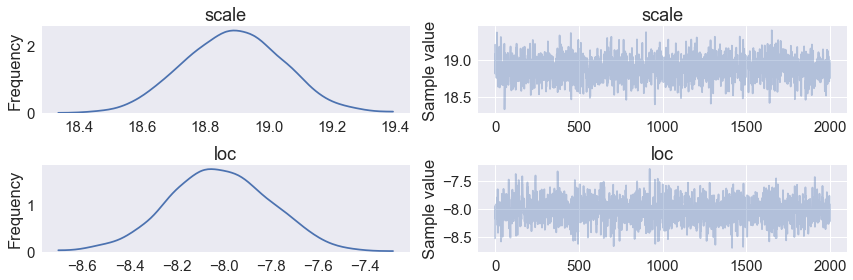

In [60]:
pm.traceplot(trace, combined=True)
pm.summary(trace)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(-200, 50)

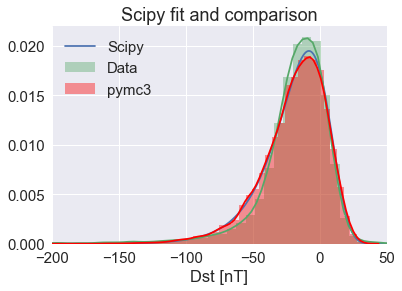

In [61]:
ppc = np.asarray([scipy.stats.gumbel_l(scale=trace['scale'][ii], 
                                       loc=trace['loc'][ii]).rvs(size=10)
                  for ii, v in enumerate(np.random.randint(0, len(trace), 1000))])
d = scipy.stats.gumbel_l.fit(dst.loc['2000'])
XX = np.linspace(-600, 100, 1000)

plt.plot(XX, scipy.stats.gumbel_l(*d).pdf(XX), label='Scipy')

sns.distplot(dst.loc['2000'], label='Data')

sns.distplot(ppc.flatten(), label='pymc3', color='r',)


plt.xlabel('Dst [nT]')
plt.title('Scipy fit and comparison')
plt.legend();
plt.xlim((-200, 50))

100%|██████████| 1000/1000 [00:00<00:00, 3360.34it/s]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(-200, 50)

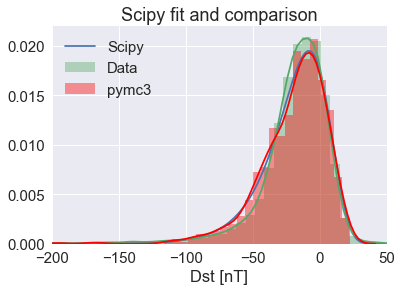

In [63]:
ppc = pm.sample_ppc(trace, samples=1000, model=model)

d = scipy.stats.gumbel_l.fit(dst.loc['2000'])
XX = np.linspace(-600, 100, 1000)

plt.plot(XX, scipy.stats.gumbel_l(*d).pdf(XX), label='Scipy')

sns.distplot(dst.loc['2000'], label='Data')

sns.distplot(ppc['gumbel_l'], label='pymc3', color='r',)


plt.xlabel('Dst [nT]')
plt.title('Scipy fit and comparison')
plt.legend();
plt.xlim((-200, 50))